<a href="https://colab.research.google.com/github/S10aki95/study/blob/main/fine_tuning_ver4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install fugashi
!pip install ipadic

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertJapaneseTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Github_Foldar/study/
#!git config --global user.email "akihirosato1020@gmail.com"
#!git config --global user.name "S10aki95"
#!git commit

/content/drive/MyDrive/Colab Notebooks/Github_Foldar/study


In [5]:
df = pd.read_csv('livedoor_news.csv')
label = df['label'].tolist()
train = df['sentence'].tolist()

df.head() #{0 : 'IT', 1 : 'スポーツ', 2 : '映画'}

,Unnamed: 0,label,sentence
0,2068,2,インタビュー：マックG監督「リメイクしたい日本のアニメは『AKIRA』かな」
1,898,1,【Sports Watch】なでしこジャパン勝利、決勝＝アメリカ戦の攻略ポイントは…
2,1971,2,女子高生シンガーのKyleeが「美人映写技師との恋」を描いた映画の主題歌担当に
3,1288,1,銀メダル・三宅宏実、試合後、同じ言葉が32回飛び出した!?
4,322,0,七人の侍によって開発された新素材！ NECのLaVie Zで使われた新素材の開発秘話【デジ通】


In [6]:
train_text, test_text, train_label, test_label = train_test_split(train, label, train_size=0.8)

JP_tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

#トークン化
train_encodings = JP_tokenizer(train_text, truncation= True, padding=True)
test_encodings = JP_tokenizer(test_text, truncation= True, padding= True)

In [7]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_label)
val_dataset = IMDbDataset(test_encodings, test_label)

In [8]:
model = BertForSequenceClassification.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking', num_labels=3)

#普通のトレーニング
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

Step,Training Loss
10,1.075700
20,1.092200
30,1.065400
40,1.028400
50,0.982100
60,0.929400
70,0.863600
80,0.724500
90,0.566900
100,0.429200




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=399, training_loss=0.2941314592434649, metrics={'train_runtime': 59.8747, 'train_samples_per_second': 105.921, 'train_steps_per_second': 6.664, 'total_flos': 130364476189920.0, 'train_loss': 0.2941314592434649, 'epoch': 3.0})

In [9]:
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
classification = pipeline("text-classification", model = model, tokenizer = JP_tokenizer, device = 0)

classification("なでしこジャパン　決勝戦、映画化決定！優勝の秘訣に迫る")

[{'label': 'LABEL_1', 'score': 0.9662666320800781}]

In [10]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 529
  Batch size = 64


{'epoch': 3.0,
 'eval_loss': 0.15481527149677277,
 'eval_runtime': 1.256,
 'eval_samples_per_second': 421.195,
 'eval_steps_per_second': 7.166}

# 学習率の調整

“How to Fine-Tune BERT for Text Classification?”の5.3.4より、レイヤー毎に学習率を変更してトレーニングさせる。基本的な発想としては、論文の(2)の式と同様に$l$番目の層に対しての学習率を$\eta^l$としたとき、
\begin{equation}
\eta^l = \xi \eta^{l + 1}
\end{equation}
として計算している。ただし、ここで$\xi (\in [0,1])$は"Decaying factor"



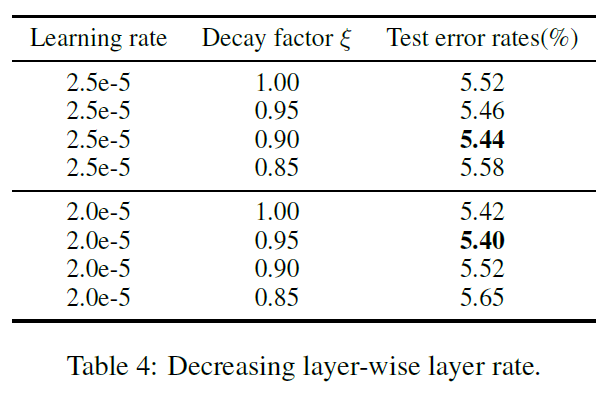

以下は、論文中の結果についてここでは、論文と同様に、


> Learning rate : $2.0e^{-5}$, Decaying Factor : $0.95$

で試してみる。

In [11]:
#モデルの読み込み
model = BertForSequenceClassification.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking', num_labels=3)

#モデルの構造を把握する
#[name for name, _ in model.state_dict().items()]

loading configuration file https://huggingface.co/cl-tohoku/bert-base-japanese-whole-word-masking/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/573af37b6c39d672f2df687c06ad7d556476cbe43e5bf7771097187c45a3e7bf.abeb707b5d79387dd462e8bfb724637d856e98434b6931c769b8716c6f287258
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transfo

In [12]:
from transformers import AdamW

Decay_factor = 0.95
learning_rate = 2.0e-5

#Emmbedding Layer, Encoder Layer 0～11, Pooling Layer, Classifer Layerの、15個のレイヤーについての学習率を用意する
LearingRate_list = [learning_rate * (Decay_factor ** i) for i in range(15)]

Emmbedding_lr = [{'params' : model.bert.embeddings.parameters(), 'lr' : LearingRate_list[0]}]
Layers_lr = [{'params' : layer.parameters(), 'lr' : LearingRate_list[i+1]} for i, layer in enumerate(model.bert.encoder.layer)]
Pooling_lr = [{'params' : model.bert.pooler.parameters(), 'lr' : LearingRate_list[13]}]
Classifer_lr = [{'params' : model.classifier.parameters(), 'lr' : LearingRate_list[14]}]

optim = AdamW(Emmbedding_lr + Layers_lr + Pooling_lr + Classifer_lr)

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

for epoch in range(3):
    running_loss = 0.0
    for i,batch in enumerate(tqdm(train_loader)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            
model.eval()

  8%|▊         | 11/133 [00:01<00:17,  7.02it/s]

[1,    10] loss: 1.078


 16%|█▌        | 21/133 [00:02<00:15,  7.16it/s]

[1,    20] loss: 0.937


 23%|██▎       | 31/133 [00:04<00:14,  7.19it/s]

[1,    30] loss: 0.772


 31%|███       | 41/133 [00:05<00:12,  7.18it/s]

[1,    40] loss: 0.614


 38%|███▊      | 51/133 [00:07<00:11,  7.18it/s]

[1,    50] loss: 0.433


 46%|████▌     | 61/133 [00:08<00:10,  7.14it/s]

[1,    60] loss: 0.325


 53%|█████▎    | 71/133 [00:09<00:08,  7.15it/s]

[1,    70] loss: 0.283


 61%|██████    | 81/133 [00:11<00:07,  7.06it/s]

[1,    80] loss: 0.304


 68%|██████▊   | 91/133 [00:12<00:05,  7.11it/s]

[1,    90] loss: 0.228


 76%|███████▌  | 101/133 [00:14<00:04,  7.11it/s]

[1,   100] loss: 0.181


 83%|████████▎ | 111/133 [00:15<00:03,  7.05it/s]

[1,   110] loss: 0.182


 91%|█████████ | 121/133 [00:17<00:01,  7.05it/s]

[1,   120] loss: 0.126


 98%|█████████▊| 131/133 [00:18<00:00,  7.12it/s]

[1,   130] loss: 0.127


  8%|▊         | 11/133 [00:01<00:17,  7.09it/s]

[2,    10] loss: 0.134


 16%|█▌        | 21/133 [00:02<00:15,  7.04it/s]

[2,    20] loss: 0.179


 23%|██▎       | 31/133 [00:04<00:14,  7.06it/s]

[2,    30] loss: 0.108


 31%|███       | 41/133 [00:05<00:13,  7.02it/s]

[2,    40] loss: 0.075


 38%|███▊      | 51/133 [00:07<00:11,  7.02it/s]

[2,    50] loss: 0.079


 46%|████▌     | 61/133 [00:08<00:10,  6.99it/s]

[2,    60] loss: 0.082


 53%|█████▎    | 71/133 [00:10<00:08,  7.01it/s]

[2,    70] loss: 0.063


 61%|██████    | 81/133 [00:11<00:07,  7.03it/s]

[2,    80] loss: 0.089


 68%|██████▊   | 91/133 [00:12<00:05,  7.00it/s]

[2,    90] loss: 0.049


 76%|███████▌  | 101/133 [00:14<00:04,  7.01it/s]

[2,   100] loss: 0.072


 83%|████████▎ | 111/133 [00:15<00:03,  7.02it/s]

[2,   110] loss: 0.046


 91%|█████████ | 121/133 [00:17<00:01,  7.02it/s]

[2,   120] loss: 0.100


 98%|█████████▊| 131/133 [00:18<00:00,  7.04it/s]

[2,   130] loss: 0.052


  8%|▊         | 11/133 [00:01<00:17,  7.04it/s]

[3,    10] loss: 0.025


 16%|█▌        | 21/133 [00:02<00:16,  6.99it/s]

[3,    20] loss: 0.014


 23%|██▎       | 31/133 [00:04<00:14,  6.99it/s]

[3,    30] loss: 0.018


 31%|███       | 41/133 [00:05<00:13,  7.03it/s]

[3,    40] loss: 0.023


 38%|███▊      | 51/133 [00:07<00:11,  7.06it/s]

[3,    50] loss: 0.016


 46%|████▌     | 61/133 [00:08<00:10,  6.98it/s]

[3,    60] loss: 0.011


 53%|█████▎    | 71/133 [00:10<00:08,  7.03it/s]

[3,    70] loss: 0.011


 61%|██████    | 81/133 [00:11<00:07,  7.03it/s]

[3,    80] loss: 0.040


 68%|██████▊   | 91/133 [00:12<00:05,  7.01it/s]

[3,    90] loss: 0.077


 76%|███████▌  | 101/133 [00:14<00:04,  7.04it/s]

[3,   100] loss: 0.019


 83%|████████▎ | 111/133 [00:15<00:03,  7.06it/s]

[3,   110] loss: 0.047


 91%|█████████ | 121/133 [00:17<00:01,  7.05it/s]

[3,   120] loss: 0.010


 98%|█████████▊| 131/133 [00:18<00:00,  7.03it/s]

[3,   130] loss: 0.023


100%|██████████| 133/133 [00:18<00:00,  7.06it/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
classification = pipeline("text-classification", model = model, tokenizer = JP_tokenizer, device = 0)

classification("少林サッカー映画、TV放送決定！")

[{'label': 'LABEL_2', 'score': 0.994263231754303}]

"ON THE STABILITY OF FINE-TUNING BERT: MISCONCEPTIONS,
EXPLANATIONS, AND STRONG BASELINES"の5.1では、Bert特有の勾配消失問題がある。下の図は、Bertの各レイヤーの損失関数の$l_2$勾配ノルムをプロットしたものである。下層レイヤーでの勾配がiteration 70を超えたあたりから、急激に発生している。

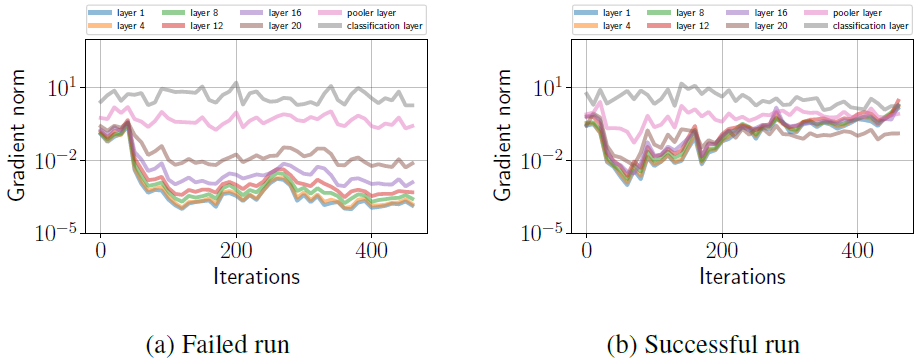

# 層(Layer)のカスタマイズ

参考資料：

1: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

2: https://github.com/huggingface/transformers/issues/5816

3: https://stackoverflow.com/questions/64156202/add-dense-layer-on-top-of-huggingface-bert-model

In [15]:
from transformers import BertModel, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[1]   #pooling layerではなく、各トークンの位置での出力が知りたいときには、こっちを採用：outputs[0][:, 'token_position', :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [16]:
model = BertClassifier()
model.to(device)
model.train()

criterion = nn.CrossEntropyLoss() ## If required define your own criterion
optimizer = AdamW(model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )


for epoch in range(3):
    for batch in tqdm(train_loader): ## If you have a DataLoader()  object to get the data.
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
           
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

loading configuration file https://huggingface.co/cl-tohoku/bert-base-japanese-whole-word-masking/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/573af37b6c39d672f2df687c06ad7d556476cbe43e5bf7771097187c45a3e7bf.abeb707b5d79387dd462e8bfb724637d856e98434b6931c769b8716c6f287258
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.9.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/cl-tohoku/bert-

# メモ

Bertの出力の内容を確認

In [17]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc7043

In [18]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [19]:
outputs[0].shape #6文字なので、8つのトークンに対応したものが出てくる

torch.Size([1, 8, 768])

In [20]:
outputs[1].shape

torch.Size([1, 768])